# Land use and Land Cover Classification

The availability of free satellite data has increased its use in several applications in the domains of agriculture, disaster recovery, climate change, urban development, or environmental monitoring can be realized. However, to fully utilize the data for the previously mentioned domains, first satellite images must be processed and transformed into structured semantics. One type of such fundamental semantics is Land Use and Land Cover Classification. The aim of land use and land cover classification is to automatically provide labels describing the represented physical land type or how a land area is used (e.g., residential, industrial)

A satellite image dataset for the task of land use and land cover classification was presented in [[1]](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8519248). The EuroSAT dataset is based on Sentinel-2 satellite images and consists of 27,000 labeled images with a total of 10 different classes listed below where the patches are 64x64 pixels each.

![alt text](./Images/dataset.png "The EuroSAT Dataset")

In this assignment you are going to use the optical bands of Sentinel-2 which are computed by combining the bands red (B04), green (B03) and blue (B02) from the Sentinel-2 product. More information about the Sentinel-2 bands can be found [here](https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi/resolutions/spatial). You will then train different Convolutional Neural Network (CNN) models to classify every 64x64 patches in one of the following classes:

1. AnnualCrop
2. Forest
3. Herbaceous Vegetation
4. Highway
5. Industrial
6. Pasture
7. Permanent Crop
8. Residential
9. River
10. SeaLake



## Instructions
The EuroSAT dataset is based on Sentinel-2 satellite images and consists of 27,000 labeled images with a total of 10 different classes. The dataset is structured as follows:
1. `train.txt`: this file contains a list of images that will be used to train the Convolutional Neural Network (CNN) models.
2. `test.txt`: this file contains a list of images that will be used to test the Convolutional Neural Network (CNN) models.
3. A list of 10 folders, each one containing the images pertaining to each class.

All code needs to be developed in Python 3 and run on a Ubuntu 20.04 environment or later versions of Ubuntu. The student is requested send the jupyter notebook using the template provided. Any textual or visual information and equations that the student might need to convey is expected to be written using the markdown language within the same Juputer Notebook. The Juputer Notebook should be named as follows

`name-surname.ipynb`

The list of packages that are allowed for this assignment are: `matplotlib`, `os`, `numpy`, `torch`, `open-cv`, `torchvision` and any other packages agreed with the lecturer.


## Assignment

**Q1:** A lot of effort in solving any machine learning and computer vision problem goes into preparing the data. PyTorch provides a simple mechanism to define a custom dataset using `torch.utils.data.Dataset`, which is an abstract class representing a dataset. Your custom dataset should inherit `Dataset` and override the following methods:

- `__init__` so that it initializes the dataset
- `__len__` so that len(dataset) returns the size of the dataset.
- `__getitem__` to support the indexing such that dataset[i] can be used to get i-th sample.


Write a class `DataLoaderClassification` that can be used to
- load the list of image filenames and the corresponding lables in two lists in `__init__`
- load a batch of images and corresponding lables when one calls `__getitem__`
- returns the length of the dataset using `__len__`

Write the code in one or more cells.

In [1]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import random
import matplotlib.pyplot as plt


Debug = True

In [2]:
###############################################
#  DataLoaderClassification() ::              #
###############################################
class DataLoaderClassification(Dataset):
    def __init__(self, data_dir, file_list_path):
        # Args:
        #    data_dir :: Path to the directory containing image subfolders.
        #    file_list_path :: Path to the text file containing image paths (e.g., train.txt or test.txt).

        self.data_dir = data_dir        
        self.image_paths = []
        self.labels = []
        
        # A set to collect unique labels
        label_set = set()
        
        with open(file_list_path, 'r') as f:
            for line in f:
                line = line.strip()
                if line:
                    updated_path = line.replace('EuroSAT/', '')  
                    self.image_paths.append(updated_path)
                    
                    label = os.path.split(updated_path)[0].replace('./Data/', '')  
                    self.labels.append(label)
                    label_set.add(label)  # Collect unique labels
                    
        # Create a mapping from label strings to integers
        self.label_to_index = {label: idx for idx, label in enumerate(sorted(label_set))}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_full_path = self.image_paths[idx]
        label = self.labels[idx]
        
        image = cv2.imread(img_full_path)
        if image is None:
            raise FileNotFoundError(f"Image at path {img_full_path} could not be loaded.")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)# Convert to RGB

        # image to tensor
        transform = transforms.ToTensor()
        image = transform(image)
        
        # Convert label from string to integer using the label mapping and, then, to tensor
        label = self.label_to_index[label]
        label = torch.tensor(label)
        
        return image, label

In [3]:
data_dir = 'Data'
train_file_list = 'Data/train.txt'
test_file_list = 'Data/test.txt'

train_dataset = DataLoaderClassification(data_dir=data_dir, file_list_path=train_file_list)
test_dataset  = DataLoaderClassification(data_dir=data_dir, file_list_path=test_file_list)

print(f"Number of items in train_dataset: {len(train_dataset)}")
print(f"Number of items in test_dataset: {len(test_dataset)}")


# test for getitem
if Debug:
    test_index = random.randint(0, 21599)
    print(f"Check item {test_index} from train_dataset")
    image, label = train_dataset[test_index]
    print(f"Image {test_index} -> Shape: {image.shape}, Label: {label}")

Number of items in train_dataset: 21600
Number of items in test_dataset: 5400
Check item 7688 from train_dataset
Image 7688 -> Shape: torch.Size([3, 64, 64]), Label: 1


**Q2:** Write the code in one cell that uses the list of files included in `train.txt` and `test.txt` to create a Pytorch dataloader for the training and testing data, respectively.

**Loading in batches**

DataLoader: Shuffling while training to prevent learning parterns related to the order.
When testing, shuffling is typically set to False to maintain the order of the test samples.

In [4]:
#num_workers = 0   # number of subprocesses to use for data loading
batch_size = 20   # how many samples per batch to load

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# test: Iterate through the dataset in batches
if Debug:
    for batch_idx, (images, labels) in enumerate(train_loader):
        print(f"\n Batch {batch_idx + 1}  \n   Image batch shape: {images.shape}, \n   Labels: {labels}")
        if batch_idx == 2:
            break



 Batch 1  
   Image batch shape: torch.Size([20, 3, 64, 64]), 
   Labels: tensor([0, 2, 0, 3, 1, 9, 2, 3, 5, 4, 6, 0, 9, 7, 1, 2, 9, 1, 7, 3])

 Batch 2  
   Image batch shape: torch.Size([20, 3, 64, 64]), 
   Labels: tensor([7, 0, 9, 2, 4, 2, 4, 8, 8, 3, 8, 4, 9, 6, 3, 7, 8, 1, 9, 4])

 Batch 3  
   Image batch shape: torch.Size([20, 3, 64, 64]), 
   Labels: tensor([1, 7, 4, 2, 3, 8, 9, 9, 1, 2, 0, 7, 6, 4, 5, 5, 1, 4, 3, 1])


**Q3:** PyTorch provides the elegantly designed modules and classes, including `torch.nn`, to help you create and train neural networks. An `nn.Module` contains layers, and a method `forward(input)` that returns the output. Write the `CNN` class to define a Convolutional Neural Network (CNN) where the first convolutional layer (`conv1`) takes 3 input channels, outputs 16 output channels and has a kernel size of 5. The output of `conv1` is fed into a ReLU followed by a Max-pooling operator. The second convolutional layer in this network (`conv2`) should have 32 filters with a kernel size of 5 followed by a ReLU and a max-pooling operator. The last layer is a fully-connected layer (`fc1`) with 10 output neurons. In this code you should define the `__init__` and `forward` member functions.

More information about `torch.nn` can be found [here](https://pytorch.org/tutorials/recipes/recipes/defining_a_neural_network.html).

In [5]:
import torch.nn as nn
import torch.nn.functional as F


###############################################
#  SimpleCNN() :: Arquitecture defined in Q3 #
###############################################
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5)
        self.fc1 = nn.Linear(in_features=32 * 13 * 13, out_features=10)

    def forward(self, x):
                                                     # --> 64x64x3 -->
        x = F.relu(self.conv1(x))                    # --> 16x60x60 (kernel_size=5 without padding)
        x = F.max_pool2d(x, kernel_size=2, stride=2) # --> 16x30x30 
        x = F.relu(self.conv2(x))                    # --> 32x26x26 (kernel_size=5 without padding)
        x = F.max_pool2d(x, kernel_size=2, stride=2) # --> 32x13x13
        x = x.view(-1, 32 * 13 * 13)                 # --> 1x5408
        x = self.fc1(x)                              # --> 1x10
        return x

Pooling with kernel size of 2 and stride of 2 (typicall choice) -> downsamples the feature map by a factor of 2

**Q4:** Write the code in one or more cells to train the CNN specified in **Q3**. Plot the accuracy against the number of epochs.  Save the best performing model in the folder `./Model/Simple-CNN/model.pth` and print the highest accuracy achieved after 100 epochs using the markdown language.

In [6]:
train_on_gpu = torch.cuda.is_available() # I have an M3, so no cuda for me 
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    
model = SimpleCNN()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()
else:
    model.to('cpu')

CUDA is not available.  Training on CPU ...
SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=5408, out_features=10, bias=True)
)


In [7]:
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim


# split train in validation + train
valid_size = 0.2  # percentage of training set to use as validation

num_train = len(train_dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
valid_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=valid_sampler)

# Debug
if Debug:
    for batch_idx, (images, labels) in enumerate(train_loader):
        print(f"\n Train batch {batch_idx + 1}  \n   Image batch shape: {images.shape}, \n   Labels: {labels}")
        if batch_idx == 2:
            break
    for batch_idx, (images, labels) in enumerate(valid_loader):
        print(f"\n Validation batch {batch_idx + 1}  \n   Image batch shape: {images.shape}, \n   Labels: {labels}")
        if batch_idx == 2:
            break


# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()
# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

# number of epochs to train the model
n_epochs = 30
valid_loss_min = np.Inf



 Train batch 1  
   Image batch shape: torch.Size([20, 3, 64, 64]), 
   Labels: tensor([7, 7, 4, 4, 6, 9, 1, 0, 5, 6, 0, 4, 7, 4, 4, 7, 3, 6, 0, 2])

 Train batch 2  
   Image batch shape: torch.Size([20, 3, 64, 64]), 
   Labels: tensor([3, 3, 4, 5, 0, 4, 1, 5, 0, 2, 5, 1, 8, 8, 7, 2, 8, 4, 0, 5])

 Train batch 3  
   Image batch shape: torch.Size([20, 3, 64, 64]), 
   Labels: tensor([7, 0, 5, 3, 4, 5, 1, 9, 7, 0, 2, 7, 8, 0, 6, 8, 6, 9, 2, 2])

 Validation batch 1  
   Image batch shape: torch.Size([20, 3, 64, 64]), 
   Labels: tensor([4, 4, 7, 2, 8, 8, 3, 4, 9, 8, 1, 0, 9, 1, 0, 1, 2, 4, 4, 2])

 Validation batch 2  
   Image batch shape: torch.Size([20, 3, 64, 64]), 
   Labels: tensor([4, 1, 0, 3, 2, 7, 0, 6, 2, 0, 6, 2, 4, 1, 0, 1, 1, 0, 0, 0])

 Validation batch 3  
   Image batch shape: torch.Size([20, 3, 64, 64]), 
   Labels: tensor([3, 7, 4, 8, 3, 4, 2, 7, 7, 9, 7, 0, 9, 7, 0, 2, 5, 7, 9, 9])


In [8]:

#######################################
#  train_model() :: Training function #
#######################################
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs, save_path="./Model/Simple-CNN/", save_name ="model.pth"):
    
    # Keep track of training and validation loss
    best_accuracy = 0.0
    valid_loss_min = np.Inf  # Initialize minimum validation loss
    train_losses, valid_losses = [], []          # Store loss values for plotting
    train_accuracies, valid_accuracies = [], []  # Store accuracy values for plotting

    for epoch in range(1, num_epochs+1):

        ###################
        # train the model # --> train_loader
        ###################
        model.train()  # Set the model to training mode
        model.train()  # Set the model to training mode
        train_loss = 0.0
        valid_loss = 0.0
        correct_train = 0
        total_train = 0        
        
        # Training phase
        for images, labels in train_loader:
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                images, labels = images.cuda(), labels.cuda()

            optimizer.zero_grad()               # Clear the gradients
            output = model(images)              # Forward pass, calculate ouput
            loss = criterion(output, labels)    # Calculate the loss
            loss.backward()                     # Backpropagation
            optimizer.step()                    # Update weights

            train_loss += loss.item() * images.size(0)  # Track training loss
            
            _, predicted = torch.max(output, 1)  # Get predicted class
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        ######################
        # validate the model # --> valid_loader
        ######################
        model.eval()  # Set the model to evaluation mode
        correct_valid = 0
        total_valid = 0

        with torch.no_grad():  # Disable gradient calculation for validation
            for images, labels in valid_loader:
                if train_on_gpu:
                    images, labels = images.cuda(), labels.cuda()

                output = model(images)                      # Forward pass
                loss = criterion(output, labels)            # Calculate the validation loss
                valid_loss += loss.item() * images.size(0)  # Track validation loss

                _, predicted = torch.max(output, 1)         # Get predicted class
                correct_valid += (predicted == labels).sum().item()
                total_valid += labels.size(0)

        # Calculate average losses
        train_loss = train_loss / len(train_loader.sampler)
        valid_loss = valid_loss / len(valid_loader.sampler)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        # Calculate training and validation accuracy
        train_accuracy = 100 * correct_train / total_train
        valid_accuracy = 100 * correct_valid / total_valid

        train_accuracies.append(train_accuracy)
        valid_accuracies.append(valid_accuracy)

        # Print training/validation statistics
        print(f'Epoch: {epoch} \tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f} \tTraining Accuracy: {train_accuracy:.2f}% \tValidation Accuracy: {valid_accuracy:.2f}%')

        # Save the model if validation loss has decreased
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        save_full_path = os.path.join(save_path, save_name)
        
        if valid_loss < valid_loss_min:
            print(f'Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model ...')
            torch.save(model.state_dict(), save_full_path)
            valid_loss_min = valid_loss  # Update minimum validation loss

    return train_losses, valid_losses, train_accuracies, valid_accuracies



    
# RUN TRAINING
train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=n_epochs)



Epoch: 1 	Training Loss: 1.810244 	Validation Loss: 1.608950 	Training Accuracy: 30.20% 	Validation Accuracy: 38.36%
Validation loss decreased (inf --> 1.608950). Saving model ...
Epoch: 2 	Training Loss: 1.488930 	Validation Loss: 1.479488 	Training Accuracy: 45.58% 	Validation Accuracy: 42.43%
Validation loss decreased (1.608950 --> 1.479488). Saving model ...
Epoch: 3 	Training Loss: 1.234655 	Validation Loss: 1.095867 	Training Accuracy: 55.95% 	Validation Accuracy: 60.23%
Validation loss decreased (1.479488 --> 1.095867). Saving model ...
Epoch: 4 	Training Loss: 1.068813 	Validation Loss: 0.905633 	Training Accuracy: 61.93% 	Validation Accuracy: 70.32%
Validation loss decreased (1.095867 --> 0.905633). Saving model ...
Epoch: 5 	Training Loss: 0.926855 	Validation Loss: 0.827295 	Training Accuracy: 66.90% 	Validation Accuracy: 71.04%
Validation loss decreased (0.905633 --> 0.827295). Saving model ...
Epoch: 6 	Training Loss: 0.832162 	Validation Loss: 0.744256 	Training Accuracy:

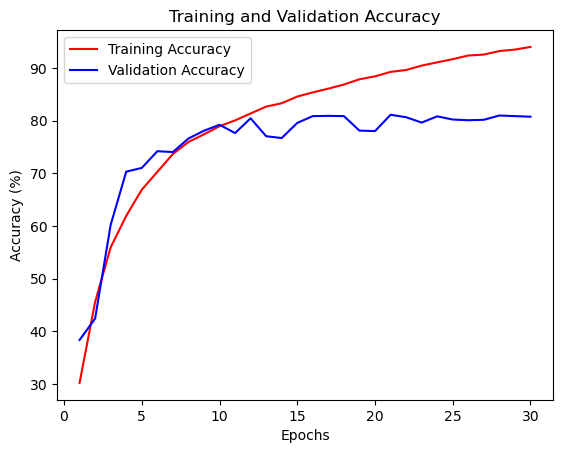

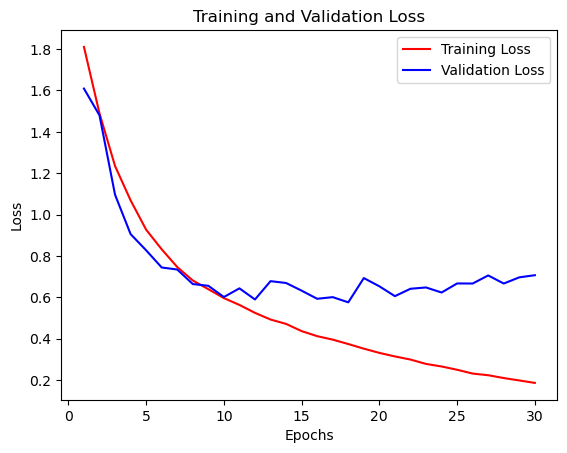

In [9]:
# Plot accuracy vs epochs
def plot_accuracy(train_accuracies, valid_accuracies, num_epochs):
    epochs = range(1, num_epochs + 1)
    plt.plot(epochs, train_accuracies, 'r', label='Training Accuracy')
    plt.plot(epochs, valid_accuracies, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()
    
# Plot loss vs epochs
def plot_loss(train_losses, valid_losses, num_epochs):
    epochs = range(1, num_epochs + 1)
    plt.plot(epochs, train_losses, 'r', label='Training Loss')
    plt.plot(epochs, valid_losses, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Plot accuracy and loss
plot_accuracy(train_accuracies, valid_accuracies, num_epochs=n_epochs)
plot_loss(train_losses, valid_losses, num_epochs=n_epochs)

The propossed model is overfitting. 

**Q5:** Your role as a researcher is to improve the performance of the current neural network. Explain the architecture that provided the best performance and describe the modifications that you think provided the gain.
    

In [10]:
# Code goes here

**Transfer learning :: ResNet50**

Transfer learning is the reuse of a pre-trained model on a new problem. In this case I am using ResNet-50, a very popular CNN that excels at image classification. I'm replacing the last fully connected layer to match the number of labels.

In [11]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT).to(device)


cpu


# Alternative Approach with Tensorflow.keras

In [12]:
# with tensorflow
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import load_model

import json
import pickle


resnet = ResNet50(input_shape=[64, 64] + [3], weights='imagenet', include_top=False)


In [13]:
##########################################################
#  DataLoaderClassification_Tensorflow() ::              #
##########################################################
class DataLoaderClassification_Tensorflow:
    def __init__(self, data_dir, file_list_path, img_size=(64, 64), num_classes=10):
        self.data_dir = data_dir
        self.image_paths = []
        self.labels = []
        self.img_size = img_size  
        self.num_classes = num_classes 

        label_set = set()

        with open(file_list_path, 'r') as f:
            for line in f:
                line = line.strip()
                if line:
                    updated_path = line.replace('EuroSAT/', '')
                    self.image_paths.append(updated_path)

                    label = os.path.split(updated_path)[0].replace('./Data/', '')
                    self.labels.append(label)
                    label_set.add(label)

        # Create a mapping from label strings to integers
        self.label_to_index = {label: idx for idx, label in enumerate(sorted(label_set))}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_full_path = self.image_paths[idx]
        label = self.labels[idx]

        # Read and preprocess image
        image = cv2.imread(img_full_path)
        if image is None:
            raise FileNotFoundError(f"Image at path {img_full_path} could not be loaded.")
        
        # Resize the image to the expected size (64x64x3)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  
        image = cv2.resize(image, self.img_size)  
        image = image / 255.0  # Normalize to [0, 1] range

        # Convert label from string to integer using the label mapping
        label = self.label_to_index[label]

        # One-hot encode the label
        label = to_categorical(label, num_classes=self.num_classes)

        # Return image in (64, 64, 3) format
        return np.array(image), np.array(label)
    
    
    
##########################################################
#  DataGenerator_Tensorflow() ::                         #
##########################################################
class DataGenerator_Tensorflow(Sequence):
    def __init__(self, dataset, batch_size, shuffle=True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.dataset))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.dataset) / self.batch_size))

    def __getitem__(self, index):
        # Generate batch indexes
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Generate data
        images = []
        labels = []
        for idx in batch_indexes:
            image, label = self.dataset[idx]
            images.append(image)
            labels.append(label)

        return np.array(images), np.array(labels)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)
            


train_dataset_tf = DataLoaderClassification_Tensorflow(data_dir=data_dir, file_list_path=train_file_list)
test_dataset_tf = DataLoaderClassification_Tensorflow(data_dir=data_dir, file_list_path=test_file_list)

            
train_loader_tf = DataGenerator_Tensorflow(train_dataset_tf, batch_size=32)
valid_loader_tf = DataGenerator_Tensorflow(test_dataset_tf, batch_size=32)


If we want to be strict, the test_dataset_tf should not be used for validation during training. Instead, the validation dataset should be derived from the train_dataset_tf, as we did with the SimpleCNN model. Once the final model is trained, its performance should be evaluated on the test_dataset_tf.

In [14]:
# Freeze the pre-trained ResNet50 layers
for layer in resnet.layers:
    layer.trainable = False

# Add custom layers for fine-tuning
x = Flatten()(resnet.output)
n_classes = 10
prediction = Dense(n_classes, activation='softmax')(x)

# Create the model with a custom name
model_ResNet50 = Model(inputs=resnet.input, outputs=prediction, name="model_ResNet50")

# Print the model summary to verify the architecture and the name
model_ResNet50.summary()

# Compile the model
model_ResNet50.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)



Model: "model_ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 70, 70, 3) │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 32, 32,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 32, 32,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 32, 32,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 34, 34,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 16, 16,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 16, 16,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 16, 16,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 16, 16,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 16, 16,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 16, 16,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 16, 16,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 16, 16,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 16, 16,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 16, 16,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 16, 16,    │      1,024 │ conv2_block1_3_c

 Total params: 23,669,642 (90.29 MB)

 Trainable params: 81,930 (320.04 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
ReTrain = True

save_tf_model = './Model/TF_ResNet50/model_ResNet50.keras'
save_tf_history = './Model/TF_ResNet50/training_history.pkl'
    
if ReTrain == True:
    steps_per_epoch = len(train_dataset) // batch_size
    validation_steps = len(test_dataset)  // batch_size

    n_epochs_tf = 2
    # Fit the model using the data loaders
    r = model_ResNet50.fit(
      train_loader_tf,
      validation_data=valid_loader_tf,
      epochs=n_epochs_tf,
      steps_per_epoch=steps_per_epoch,
      validation_steps=validation_steps
    )
    
    
    print(f"Saving model in {save_tf_model}")
    model_ResNet50.save(save_tf_model)
    
    print(f"Saving history in {save_tf_history}")
    with open(save_tf_history, 'wb') as f:
        pickle.dump(r, f)

Epoch 1/2
   2/1080 ━━━━━━━━━━━━━━━━━━━━ 1:16 71ms/step - accuracy: 0.1562 - loss: 2.4251

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 675/1080 ━━━━━━━━━━━━━━━━━━━━ 28s 71ms/step - accuracy: 0.2584 - loss: 2.0874

2024-09-09 19:47:54.712863: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1080/1080 ━━━━━━━━━━━━━━━━━━━━ 62s 56ms/step - accuracy: 0.2818 - loss: 2.0338 - val_accuracy: 0.4033 - val_loss: 1.7599
Epoch 2/2
   1/1080 ━━━━━━━━━━━━━━━━━━━━ 1:44 97ms/step - accuracy: 0.4375 - loss: 1.6535

2024-09-09 19:48:07.276312: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 643/1080 ━━━━━━━━━━━━━━━━━━━━ 31s 71ms/step - accuracy: 0.3817 - loss: 1.7382

In [ ]:
# Load previous model
if ReTrain == False:
    model = load_model('./Model/TF_ResNet50/model_ResNet50.keras')
    with open('./Model/TF_ResNet50/training_history.pkl', 'rb') as f:
        r = pickle.load(f)
        
        
# Print the final training and validation accuracy and loss
final_train_acc = r.history['accuracy'][-1]
final_val_acc = r.history['val_accuracy'][-1]
final_train_loss = r.history['loss'][-1]
final_val_loss = r.history['val_loss'][-1]

print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")

# Find the best validation accuracy and loss
best_val_acc = max(r.history['val_accuracy'])
best_val_loss = min(r.history['val_loss'])

print(f"Best Validation Accuracy: {best_val_acc:.4f}")
print(f"Best Validation Loss: {best_val_loss:.4f}")


In [ ]:
def plot_loss_accuracy(history):
    plt.figure(figsize=(12, 4))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

# Assuming r is the history object returned from model.fit()
plot_loss_accuracy(r)

In [ ]:
y_pred_prob = model_ResNet50.predict(valid_loader_tf)  # Predict probabilities
y_true = np.concatenate([y for x, y in valid_loader_tf], axis=0)  # True labels

# Compute ROC curve and ROC area for each class (assuming binary classification)
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])  # For class 1
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()